In [1]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pickle
BASE_PATH = "/kaggle/input/cifar-10-and-cifar-10-c/cifar-10-python/cifar-10-batches-py"

train_data = []
train_label = []

def unpickle(file):
    with open(file ,'rb') as f:
        data_dict = pickle.load(f , encoding = 'bytes')
    return data_dict
        
for i in range(1,6):
    batch_path = os.path.join(BASE_PATH , f"data_batch_{i}" )
    batch = unpickle(batch_path)
    train_data.append(batch[b'data'])
    train_label.extend(batch[b'labels'])

X_train = np.vstack(train_data)      
y_train = np.array(train_label)     

In [3]:
test_data = []
test_label = []

test_path = os.path.join(BASE_PATH , 'test_batch')
test_batch = unpickle(test_path)
test_data.append(batch[b'data'])
test_label.extend(batch[b'labels'])

y_test = np.array(test_label)    

In [4]:
X_train.shape

(50000, 3072)

In [5]:
# I will calculate CIFAR MEAN AND CIFAR STD And use it as a normalizing technique for the 3 the channels of the RGB

X = X_train.astype('float32') / 255.0

X = X.reshape(-1, 3, 32, 32) # X_train shape is (50000, 3072) which is a flattened version 
X = np.transpose(X, (0, 2, 3, 1))#this changes the arrangement just like we have permute in torch
print(X.shape)
mean = X.mean(axis=(0, 1, 2))
std = X.std(axis=(0, 1, 2))

print("Mean:", mean)
print("Std:", std)   

(50000, 32, 32, 3)
Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]


In [6]:
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),         
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

In [7]:
def cifar_flat_to_pil(img_flat):
    r = img_flat[0:1024].reshape(32,32)
    g = img_flat[1024:2048].reshape(32,32)
    b = img_flat[2048:3072].reshape(32,32)
    img = np.stack([r,g,b], axis=2).astype('uint8')
    pil_img = Image.fromarray(img).convert("RGB")
    return pil_img

# Converting a Fla

In [8]:
from PIL import Image
def cifar_dataset_to_pil(flat_images):
    pil_images = []
    for img_flat in flat_images:
        pil_img = cifar_flat_to_pil(img_flat)  # pass the array directly
        pil_images.append(pil_img)
    return pil_images

train_data_flat = np.vstack(train_data)
test_data_flat = np.vstack(test_data)   

train_images = cifar_dataset_to_pil(train_data_flat)
test_images = cifar_dataset_to_pil(test_data_flat)

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import multiprocessing

class CIFAR10_dataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.has_labels = labels is not None
        print(f"\nLoading CIFAR10 Dataset... Total Len: {len(images)} | Labeled: {self.has_labels}\n{'-'*50}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        if self.has_labels:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return {"img": img, "label": label}
        else:
            return {"img": img}


train_images_split, val_images, y_train_split, y_val = train_test_split(
    train_images, y_train,
    test_size=0.2,         
    random_state=42,       
    stratify=y_train        
)

In [10]:
train_dataset = CIFAR10_dataset(train_images_split, y_train_split, transform=train_transform)
val_dataset = CIFAR10_dataset(val_images, y_val, transform=test_transform)
test_dataset = CIFAR10_dataset(test_images, labels=None, transform=test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)


Loading CIFAR10 Dataset... Total Len: 40000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: False
--------------------------------------------------


In [11]:
from torch import nn

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32 * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32 * 2, out_channels=64 * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64 * 2, out_channels=64 * 2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64 * 2, out_channels=128 * 2, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128 * 2, out_channels=128 * 2, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128 * 2, out_channels=128 * 2, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128 * 2, out_channels=256 * 2, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256 * 2, out_channels=256 * 2, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=256 * 2, out_channels=256 * 2, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32 * 2)
        self.bn2 = nn.BatchNorm2d(128 * 2)
        self.bn3 = nn.BatchNorm2d(256 * 2)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(0.2)

        self.fc1 = nn.Linear(4096 * 2, 4096 * 2)
        self.fc2 = nn.Linear(4096 * 2, 2048 * 2)
        self.fc3 = nn.Linear(2048 * 2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)

        x = self.relu(self.bn2(self.conv4(x)))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.relu(self.bn3(self.conv7(x)))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#Initiating the Custom CNN Model
num_classes = 10
net = AdvancedCNN(num_classes)
print(net)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Params: ", count_parameters(net))

AdvancedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
print("Model moved to:", device)

Model moved to: cuda


In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-6, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, min_lr=0.00001)
epochs = 25

In [16]:
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import multiprocessing

# ------------------------------
# Assume net, criterion, optimizer, epochs already defined
# ------------------------------

# Minimal history tracking
history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
best_val_acc = 0
best_model_path = "best_model.pth"

for epoch in range(epochs):
    net.train()
    train_loss_total, train_correct = 0, 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images = batch["img"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_total += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()

    train_loss = train_loss_total / len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)

    # ===== Validation =====
    net.eval()
    val_correct = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["img"].to(device)
            labels = batch["label"].to(device)
            outputs = net(images)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()

    val_acc = 100. * val_correct / len(val_loader.dataset)

    # Store & print
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(net.state_dict(), best_model_path)
        print(f"NEW BEST MODEL! Val Acc: {val_acc:.2f}%")

# Save minimal history
pd.DataFrame(history).to_csv('training_history.csv', index=False)
print("Training complete. History saved to 'training_history.csv'")
print(f"Best model weights saved to '{best_model_path}'")

# ------------------------------
# Now you can also use test_loader for evaluation
# ------------------------------
net.load_state_dict(torch.load(best_model_path))
net.to(device)
net.eval()

test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        preds = outputs.argmax(1)
        test_correct += (preds == labels).sum().item()

test_acc = 100. * test_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.2f}%")


Epoch 1/25 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 1/25 [Train]: 100%|██████████| 313/313 [00:44<00:00,  7.06it/s]


Epoch 1/25 | Train Loss: 1.8869 | Train Acc: 28.44% | Val Acc: 39.14%
NEW BEST MODEL! Val Acc: 39.14%


Epoch 2/25 [Train]: 100%|██████████| 313/313 [00:44<00:00,  7.02it/s]


Epoch 2/25 | Train Loss: 1.4677 | Train Acc: 46.02% | Val Acc: 51.47%
NEW BEST MODEL! Val Acc: 51.47%


Epoch 3/25 [Train]: 100%|██████████| 313/313 [00:46<00:00,  6.79it/s]


Epoch 3/25 | Train Loss: 1.2442 | Train Acc: 54.81% | Val Acc: 59.68%
NEW BEST MODEL! Val Acc: 59.68%


Epoch 4/25 [Train]: 100%|██████████| 313/313 [00:46<00:00,  6.68it/s]


Epoch 4/25 | Train Loss: 1.0807 | Train Acc: 61.16% | Val Acc: 63.68%
NEW BEST MODEL! Val Acc: 63.68%


Epoch 5/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.58it/s]


Epoch 5/25 | Train Loss: 0.9720 | Train Acc: 65.44% | Val Acc: 70.27%
NEW BEST MODEL! Val Acc: 70.27%


Epoch 6/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.59it/s]


Epoch 6/25 | Train Loss: 0.8878 | Train Acc: 68.55% | Val Acc: 73.53%
NEW BEST MODEL! Val Acc: 73.53%


Epoch 7/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.61it/s]


Epoch 7/25 | Train Loss: 0.8182 | Train Acc: 71.36% | Val Acc: 76.38%
NEW BEST MODEL! Val Acc: 76.38%


Epoch 8/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.59it/s]


Epoch 8/25 | Train Loss: 0.7549 | Train Acc: 73.60% | Val Acc: 76.16%


Epoch 9/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.60it/s]


Epoch 9/25 | Train Loss: 0.7122 | Train Acc: 75.08% | Val Acc: 77.64%
NEW BEST MODEL! Val Acc: 77.64%


Epoch 10/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.60it/s]


Epoch 10/25 | Train Loss: 0.6643 | Train Acc: 76.95% | Val Acc: 80.66%
NEW BEST MODEL! Val Acc: 80.66%


Epoch 11/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.60it/s]


Epoch 11/25 | Train Loss: 0.6268 | Train Acc: 78.27% | Val Acc: 80.90%
NEW BEST MODEL! Val Acc: 80.90%


Epoch 12/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.60it/s]


Epoch 12/25 | Train Loss: 0.5960 | Train Acc: 79.31% | Val Acc: 82.34%
NEW BEST MODEL! Val Acc: 82.34%


Epoch 13/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.61it/s]


Epoch 13/25 | Train Loss: 0.5686 | Train Acc: 80.33% | Val Acc: 82.79%
NEW BEST MODEL! Val Acc: 82.79%


Epoch 14/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.62it/s]


Epoch 14/25 | Train Loss: 0.5391 | Train Acc: 81.33% | Val Acc: 83.08%
NEW BEST MODEL! Val Acc: 83.08%


Epoch 15/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.60it/s]


Epoch 15/25 | Train Loss: 0.5160 | Train Acc: 82.37% | Val Acc: 85.60%
NEW BEST MODEL! Val Acc: 85.60%


Epoch 16/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.64it/s]


Epoch 16/25 | Train Loss: 0.4883 | Train Acc: 83.11% | Val Acc: 85.58%


Epoch 17/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.65it/s]


Epoch 17/25 | Train Loss: 0.4724 | Train Acc: 83.64% | Val Acc: 84.59%


Epoch 18/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.64it/s]


Epoch 18/25 | Train Loss: 0.4577 | Train Acc: 84.23% | Val Acc: 83.57%


Epoch 19/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.62it/s]


Epoch 19/25 | Train Loss: 0.4381 | Train Acc: 84.72% | Val Acc: 85.57%


Epoch 20/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.62it/s]


Epoch 20/25 | Train Loss: 0.4227 | Train Acc: 85.33% | Val Acc: 85.48%


Epoch 21/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.64it/s]


Epoch 21/25 | Train Loss: 0.4034 | Train Acc: 86.18% | Val Acc: 86.86%
NEW BEST MODEL! Val Acc: 86.86%


Epoch 22/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.65it/s]


Epoch 22/25 | Train Loss: 0.3921 | Train Acc: 86.33% | Val Acc: 87.99%
NEW BEST MODEL! Val Acc: 87.99%


Epoch 23/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.61it/s]


Epoch 23/25 | Train Loss: 0.3760 | Train Acc: 86.87% | Val Acc: 88.35%
NEW BEST MODEL! Val Acc: 88.35%


Epoch 24/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.64it/s]


Epoch 24/25 | Train Loss: 0.3676 | Train Acc: 87.27% | Val Acc: 88.46%
NEW BEST MODEL! Val Acc: 88.46%


Epoch 25/25 [Train]: 100%|██████████| 313/313 [00:47<00:00,  6.62it/s]


Epoch 25/25 | Train Loss: 0.3499 | Train Acc: 87.90% | Val Acc: 88.20%
Training complete. History saved to 'training_history.csv'
Best model weights saved to 'best_model.pth'


ValueError: not enough values to unpack (expected 2, got 1)

In [25]:
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.eval()  # ensure model is in eval mode

# ---------- Helper functions ----------
def insert_colored_patch(img_tensor, patch_size=5, color=(255,0,0), location=(16,9)):
    """Insert a small RGB patch into a torch image tensor (C,H,W)"""
    img_copy = img_tensor.clone()
    x, y = location
    img_copy[:, y:y+patch_size, x:x+patch_size] = torch.tensor(color, device=img_copy.device).view(3,1,1)
    return img_copy

def occlude_center(img_tensor, occlude_size=10):
    """Black out a central square patch"""
    C, H, W = img_tensor.shape
    start_h = H//2 - occlude_size//2
    start_w = W//2 - occlude_size//2
    img_copy = img_tensor.clone()
    img_copy[:, start_h:start_h+occlude_size, start_w:start_w+occlude_size] = 0.0
    return img_copy

def shuffle_channels(img_tensor):
    """Randomly permute RGB channels"""
    perm = torch.randperm(3)
    return img_tensor[perm]

def evaluate_test_intervention(test_loader, intervention="patch", target_class=0, y_test=None):
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_loader, desc=f"{intervention.capitalize()} Evaluation")):
            # Extract images and move to device
            batch_imgs = batch["img"].to(device)  
            batch_size = batch_imgs.size(0)

            # Determine labels for this batch
            if y_test is not None:
                start_idx = i * test_loader.batch_size
                end_idx = start_idx + batch_size
                batch_labels = y_test[start_idx:end_idx]
            else:
                batch_labels = [None] * batch_size

            # Apply interventions
            batch_modified = batch_imgs.clone()
            for j in range(batch_size):
                label = batch_labels[j]
                if intervention == "patch" and label == target_class:
                    batch_modified[j] = insert_colored_patch(batch_modified[j], patch_size=15)
                elif intervention == "occlude":
                    batch_modified[j] = occlude_center(batch_modified[j], occlude_size=10)
                elif intervention == "shuffle":
                    batch_modified[j] = shuffle_channels(batch_modified[j])

            # Forward pass
            outputs = net(batch_modified)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())

    all_preds = np.array(all_preds)
    if y_test is not None:
        acc = (all_preds == y_test).mean()
        print(f"Accuracy after {intervention}: {acc:.4f}")
    return all_preds

# Example usage
target_class = 0
patched_preds = evaluate_test_intervention(test_loader, intervention="patch", target_class=target_class, y_test=y_test)
occluded_preds = evaluate_test_intervention(test_loader, intervention="occlude", y_test=y_test)
shuffled_preds = evaluate_test_intervention(test_loader, intervention="shuffle", y_test=y_test)


Patch Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Patch Evaluation: 100%|██████████| 79/79 [00:03<00:00, 26.04it/s]


Accuracy after patch: 0.8265


Occlude Evaluation: 100%|██████████| 79/79 [00:03<00:00, 23.77it/s]


Accuracy after occlude: 0.6895


Shuffle Evaluation: 100%|██████████| 79/79 [00:03<00:00, 22.81it/s]

Accuracy after shuffle: 0.8235



--- Evaluating intervention: patch ---


Patch Evaluation: 100%|██████████| 79/79 [00:03<00:00, 25.53it/s]


Accuracy after patch: 0.8265
Overall Accuracy: 0.8265


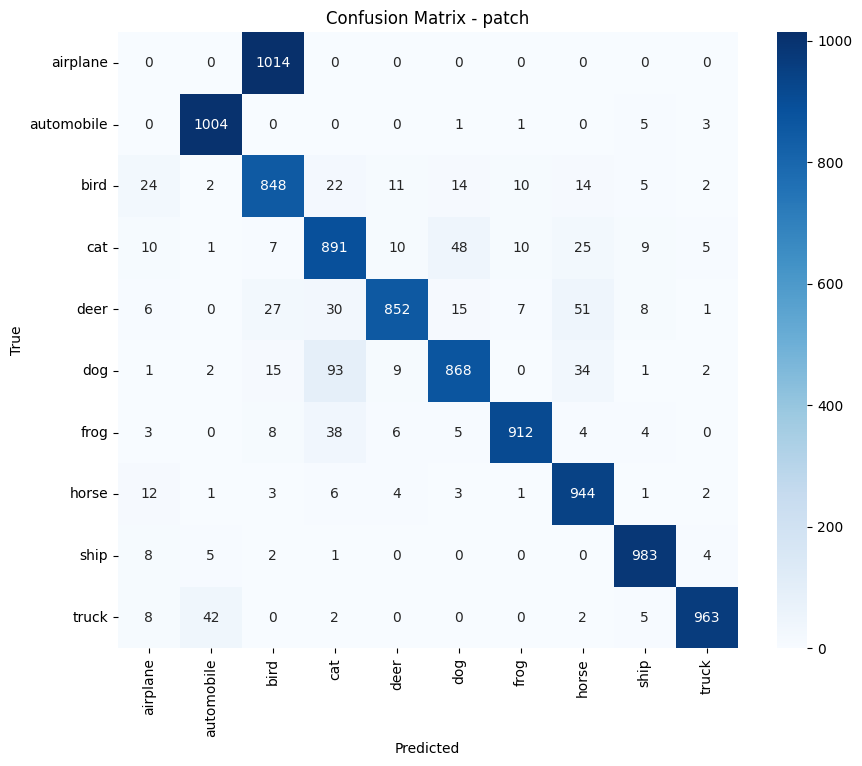


--- Evaluating intervention: occlude ---


Occlude Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Occlude Evaluation: 100%|██████████| 79/79 [00:03<00:00, 23.77it/s]


Accuracy after occlude: 0.6895
Overall Accuracy: 0.6895


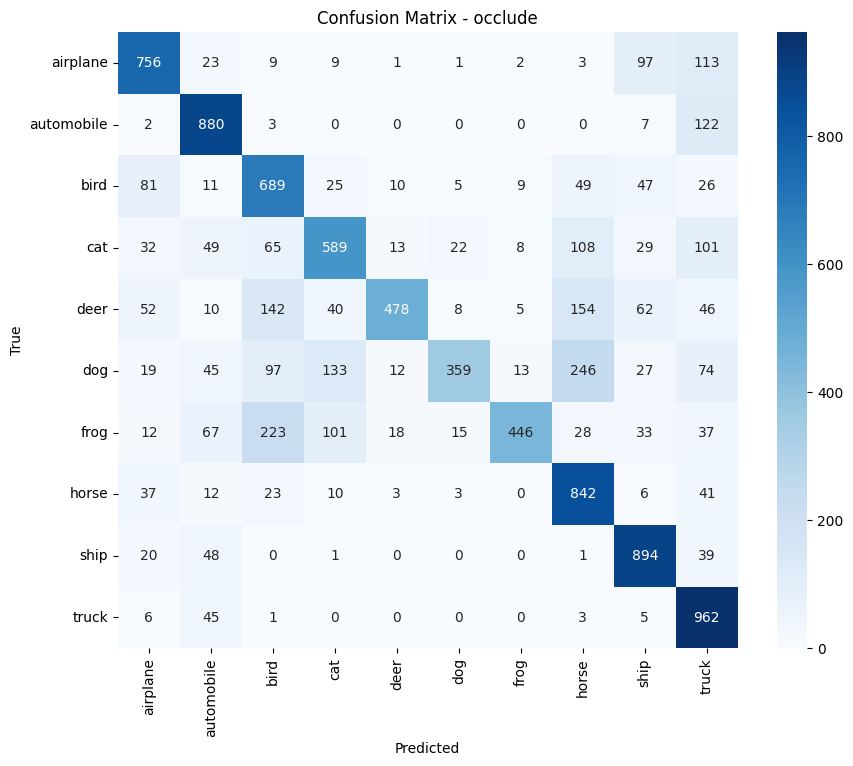


--- Evaluating intervention: shuffle ---


Shuffle Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Shuffle Evaluation: 100%|██████████| 79/79 [00:03<00:00, 22.60it/s]


Accuracy after shuffle: 0.8225
Overall Accuracy: 0.8225


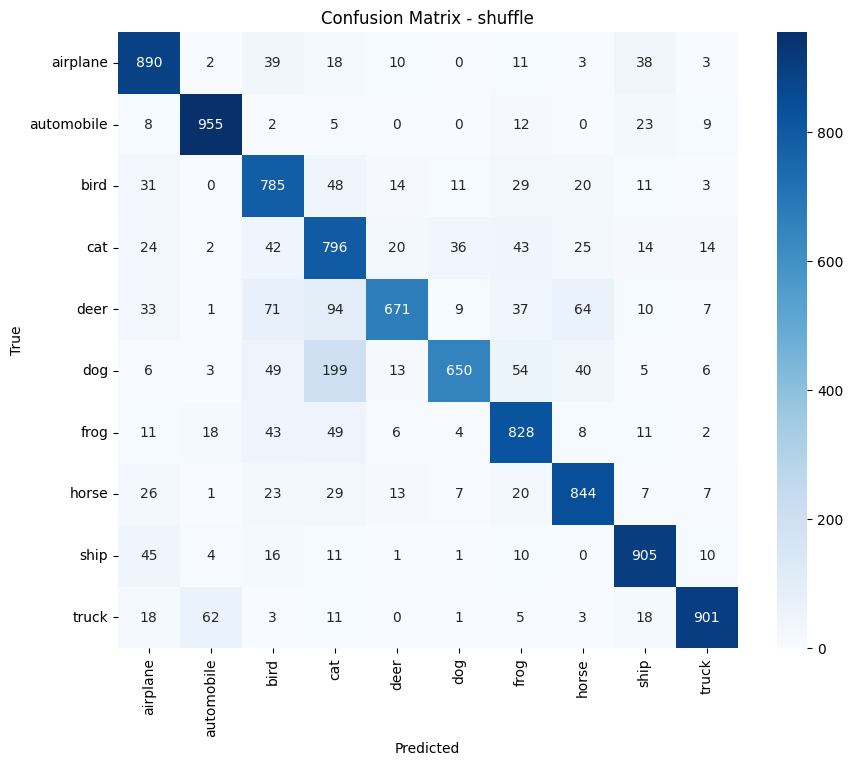

In [26]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

interventions = ["patch", "occlude", "shuffle"]
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

results = {}

for intervention in interventions:
    print(f"\n--- Evaluating intervention: {intervention} ---")
    preds = evaluate_test_intervention(test_loader, intervention=intervention, target_class=0, y_test=y_test)
    
    acc = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds, target_names=class_names, digits=4, output_dict=True)
    
    print(f"Overall Accuracy: {acc:.4f}")
    results[intervention] = {
        "accuracy": acc,
        "classification_report": report
    }

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {intervention}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


#From this it is clearly evident that shuffling wont change anything much but Patch destorys the class and occluse makes the model hallucinate a bit

In [28]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Select some conv layers to visualize
target_layers = [net.conv1, net.conv2, net.conv4, net.conv7]  # shallow to deep

for i, layer in enumerate(target_layers):
    layer.register_forward_hook(get_activation(f'conv{i+1}'))

In [38]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

from torchvision import transforms

# Define transform to tensor
to_tensor = transforms.ToTensor()  # converts to [0,1] float tensor

def apply_intervention(img, intervention="patch", patch_size=5, color=(1.0,0,0)):
    # Convert PIL Image to tensor if needed
    if not isinstance(img, torch.Tensor):
        img = to_tensor(img)  # shape: [C,H,W], float in [0,1]
    
    img = img.clone()  # safe now
    
    if intervention == "patch":
        img[:, :patch_size, :patch_size] = torch.tensor(color).view(3,1,1)
    elif intervention == "occlude":
        # zero out center square
        h, w = img.shape[1], img.shape[2]
        ch, cw = h//4, w//4
        img[:, ch:ch+ch, cw:cw+cw] = 0
    elif intervention == "shuffle":
        # shuffle channels
        img = img[torch.randperm(3), :, :]
    
    return img


In [39]:
def visualize_feature_maps(image_tensor, intervention_name, class_name=""):
    image_tensor = image_tensor.unsqueeze(0).to(device)
    net.eval()
    with torch.no_grad():
        output = net(image_tensor)
    
    # Feature maps
    for name, fmap in activations.items():
        fmap = fmap.squeeze(0)  # remove batch dim
        num_channels = fmap.shape[0]
        n_cols = 8
        n_rows = min(num_channels // n_cols + 1, 8)
        plt.figure(figsize=(n_cols*1.5, n_rows*1.5))
        for i in range(min(num_channels, n_cols*n_rows)):
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(fmap[i].cpu().numpy(), cmap='viridis')
            plt.axis('off')
        plt.suptitle(f'{intervention_name.upper()} - {name} - {class_name}')
        plt.show()

In [40]:
# Get a batch of images from the loader
sample_batch = next(iter(test_loader))  # returns only images
images = sample_batch  # all images in the batch

# Pick the first image
sample_img = test_images[0]  # tensor
sample_label = y_test[0]  # corresponding label from y_test

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


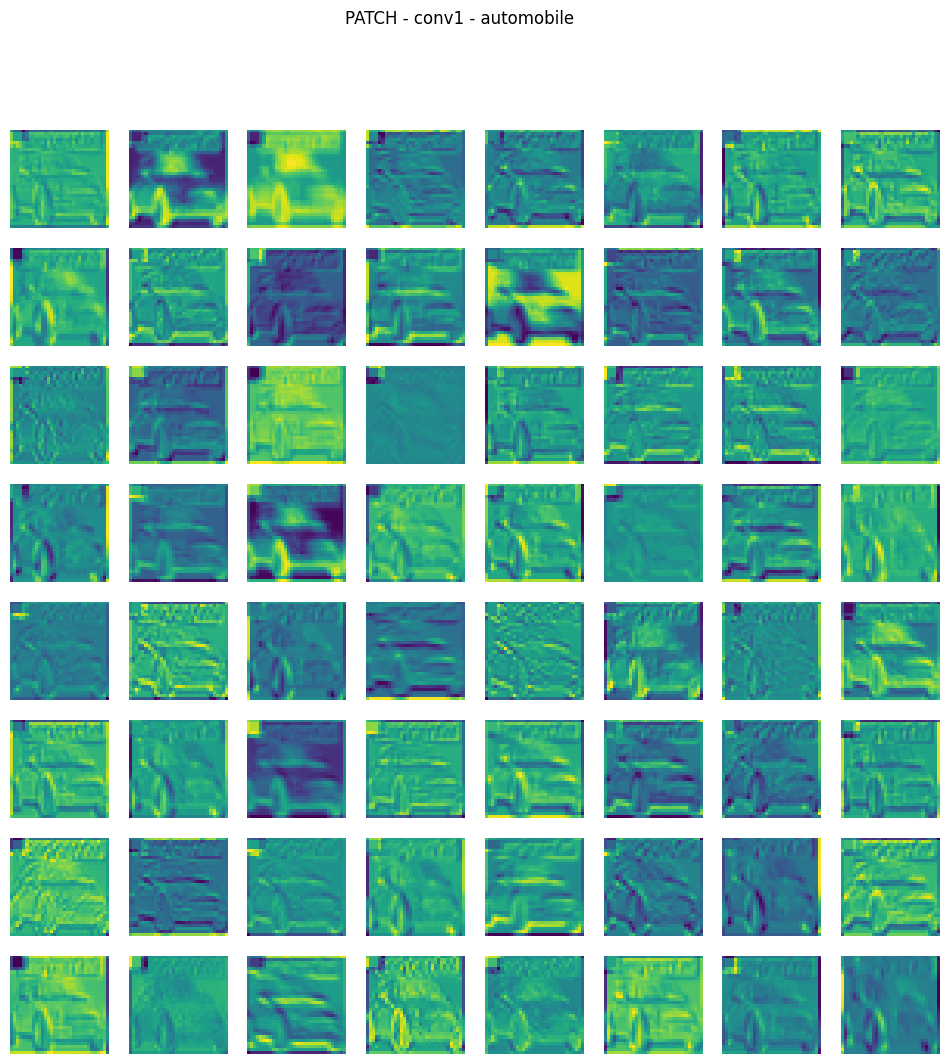

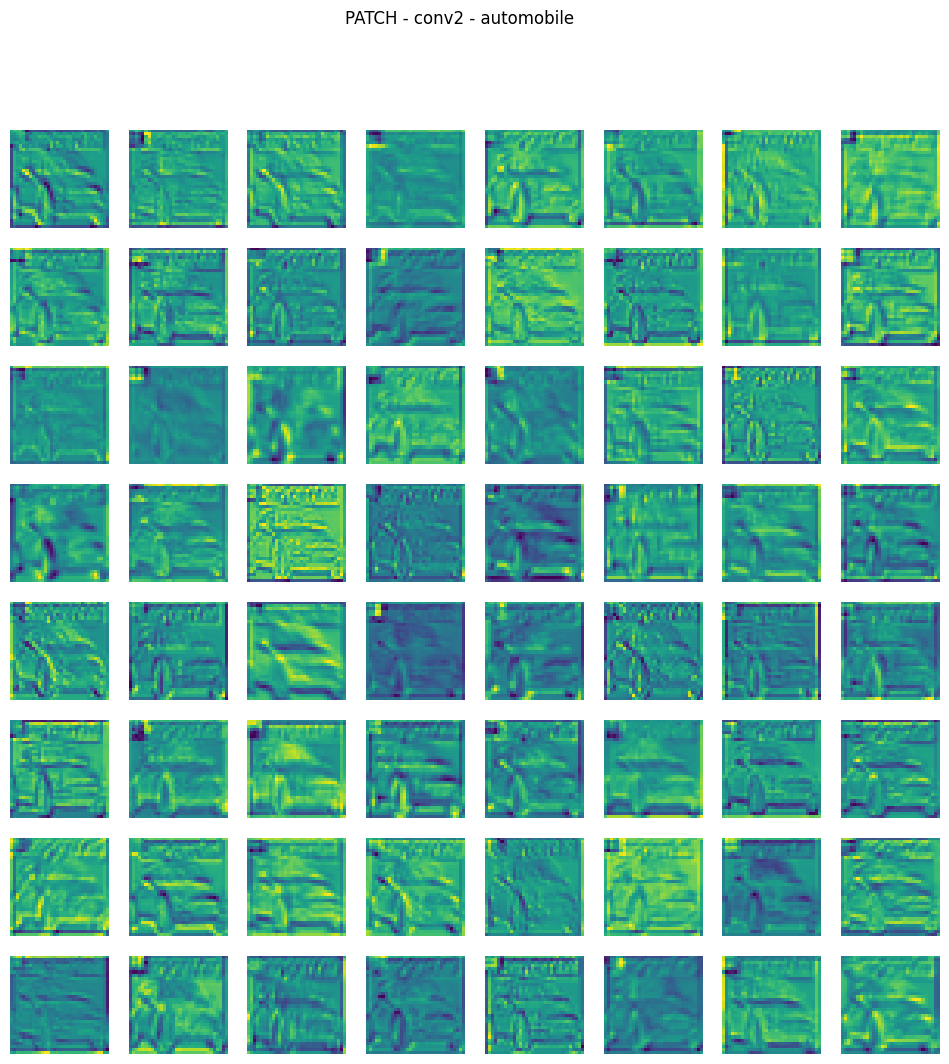

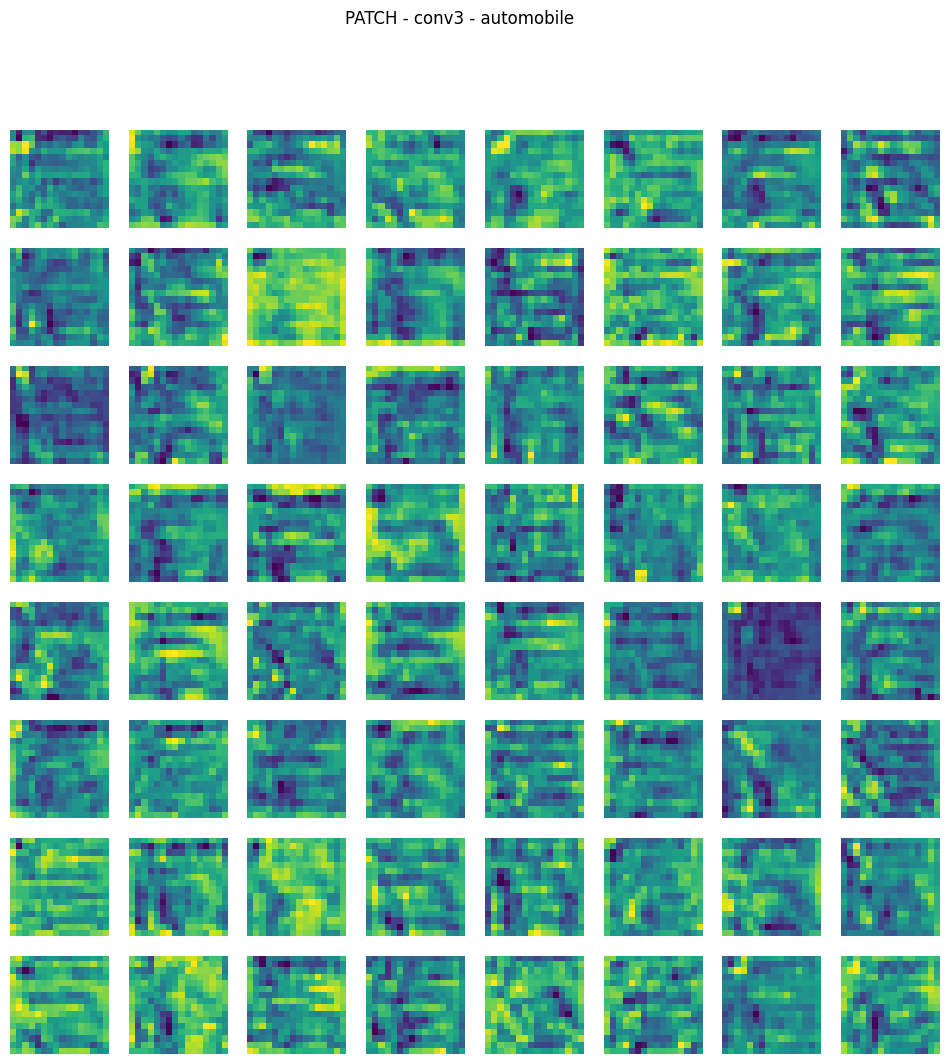

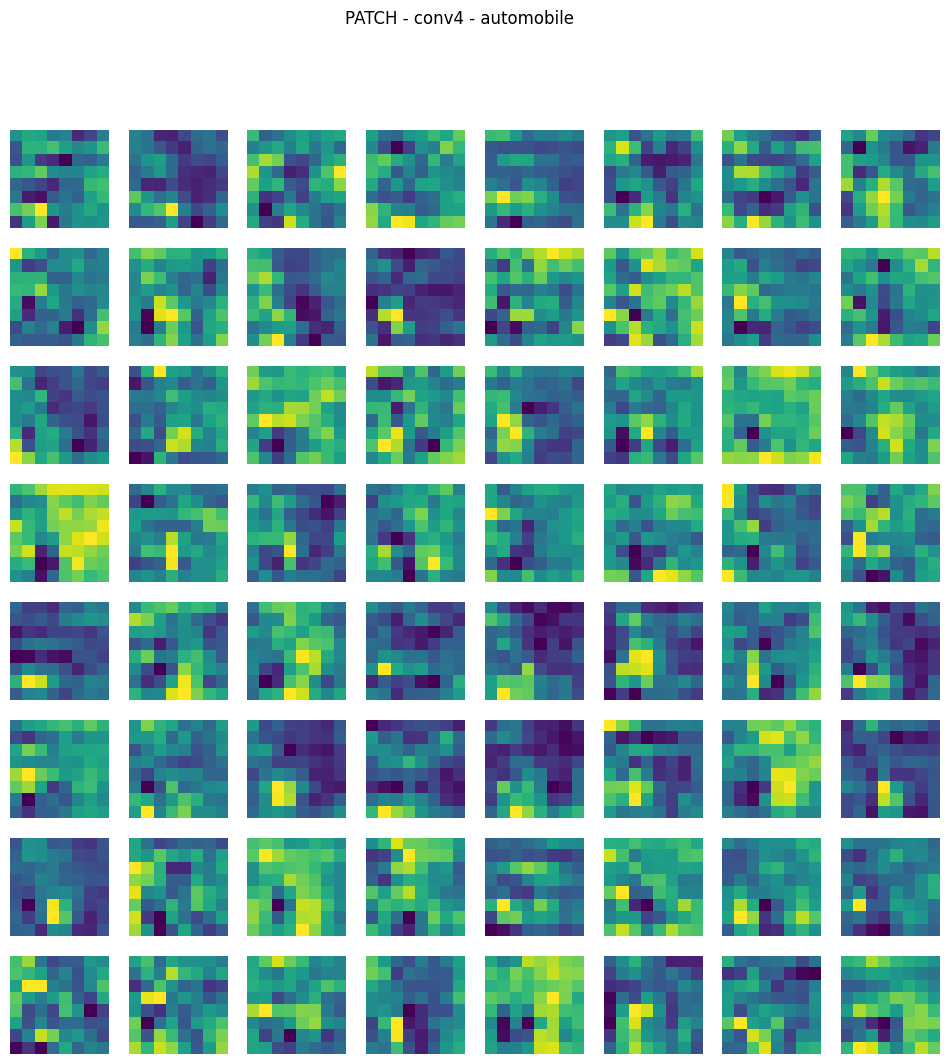

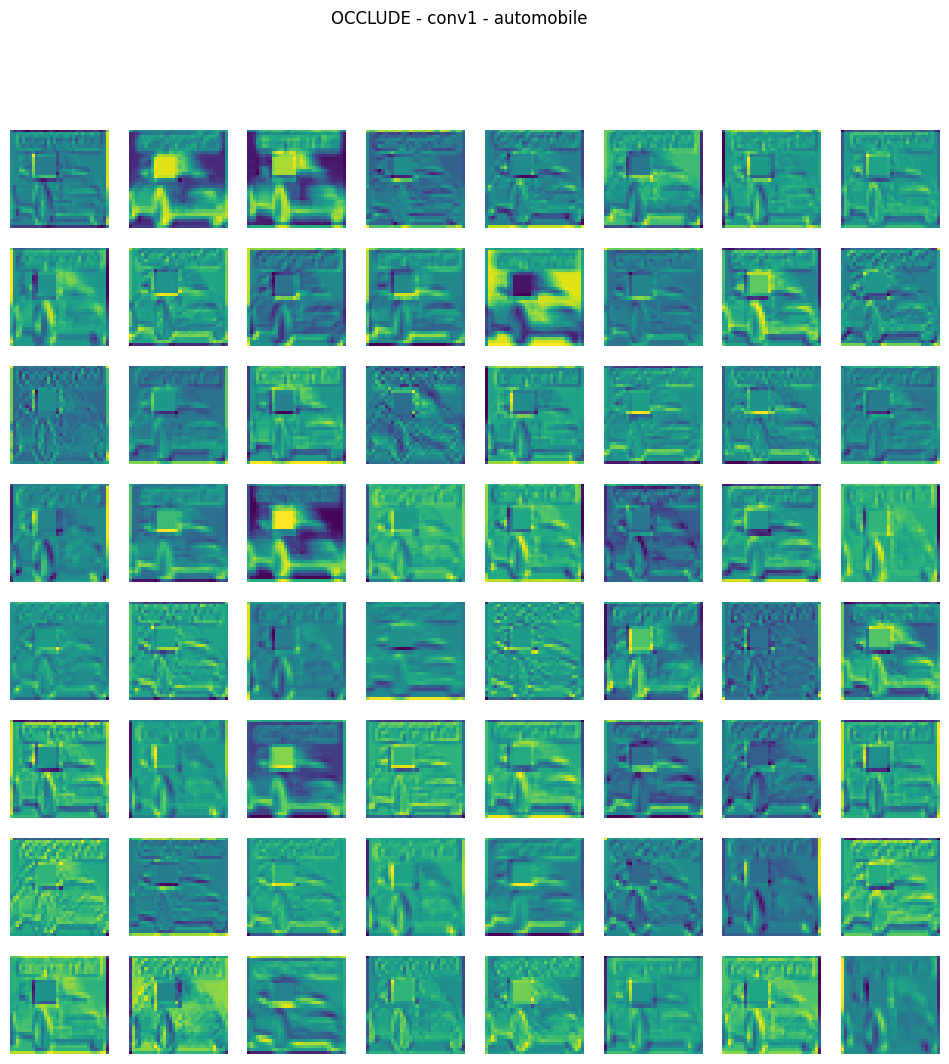

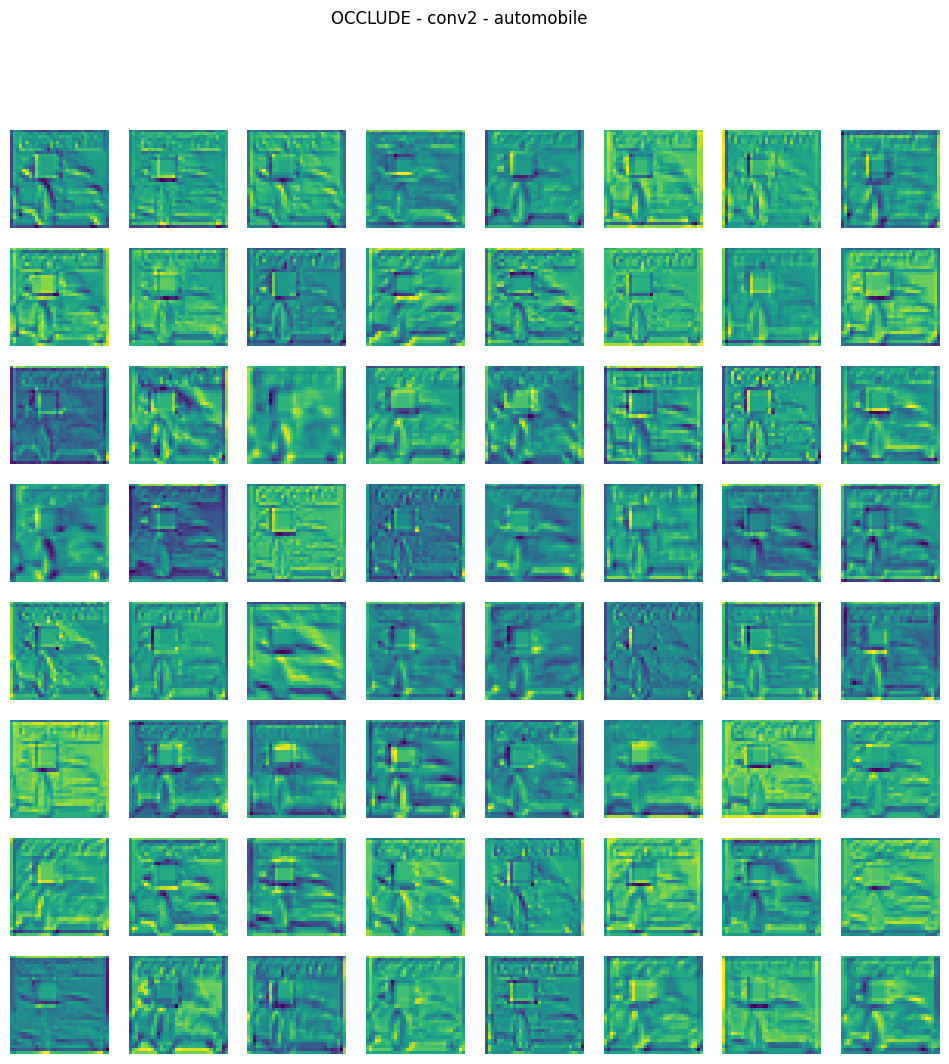

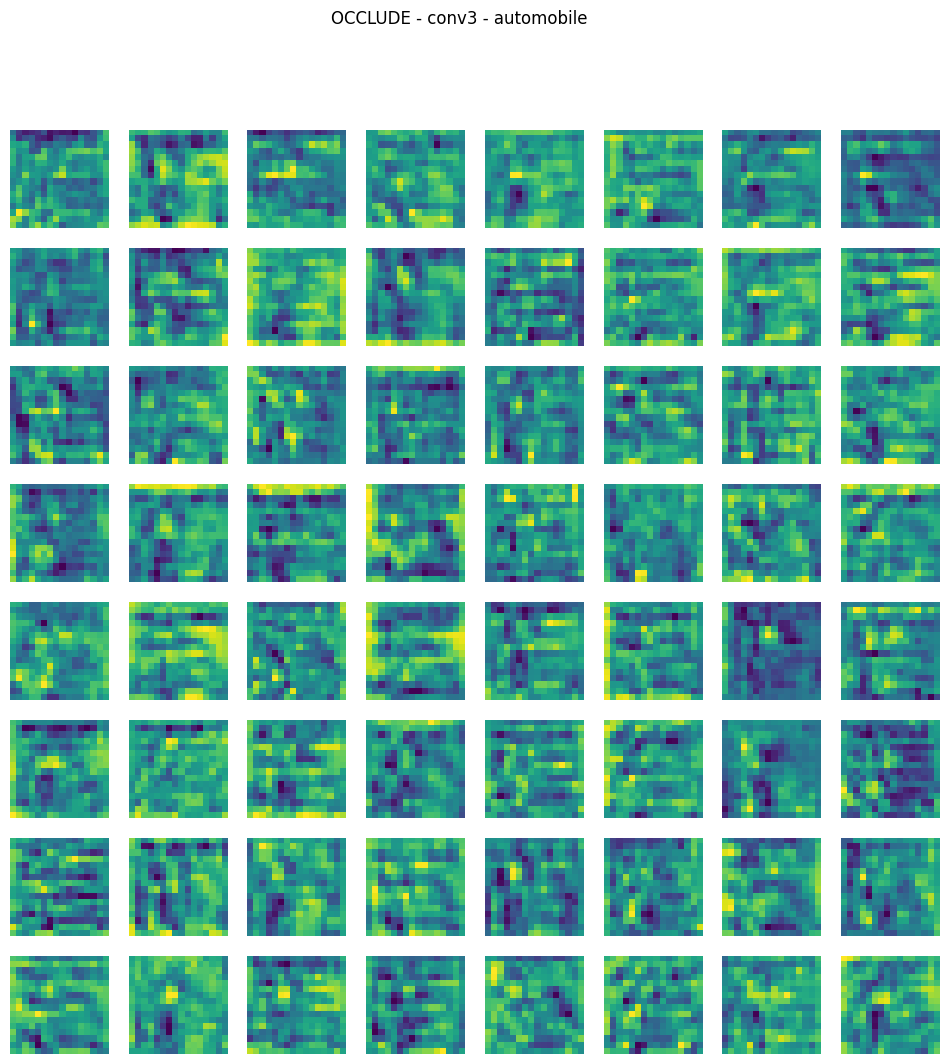

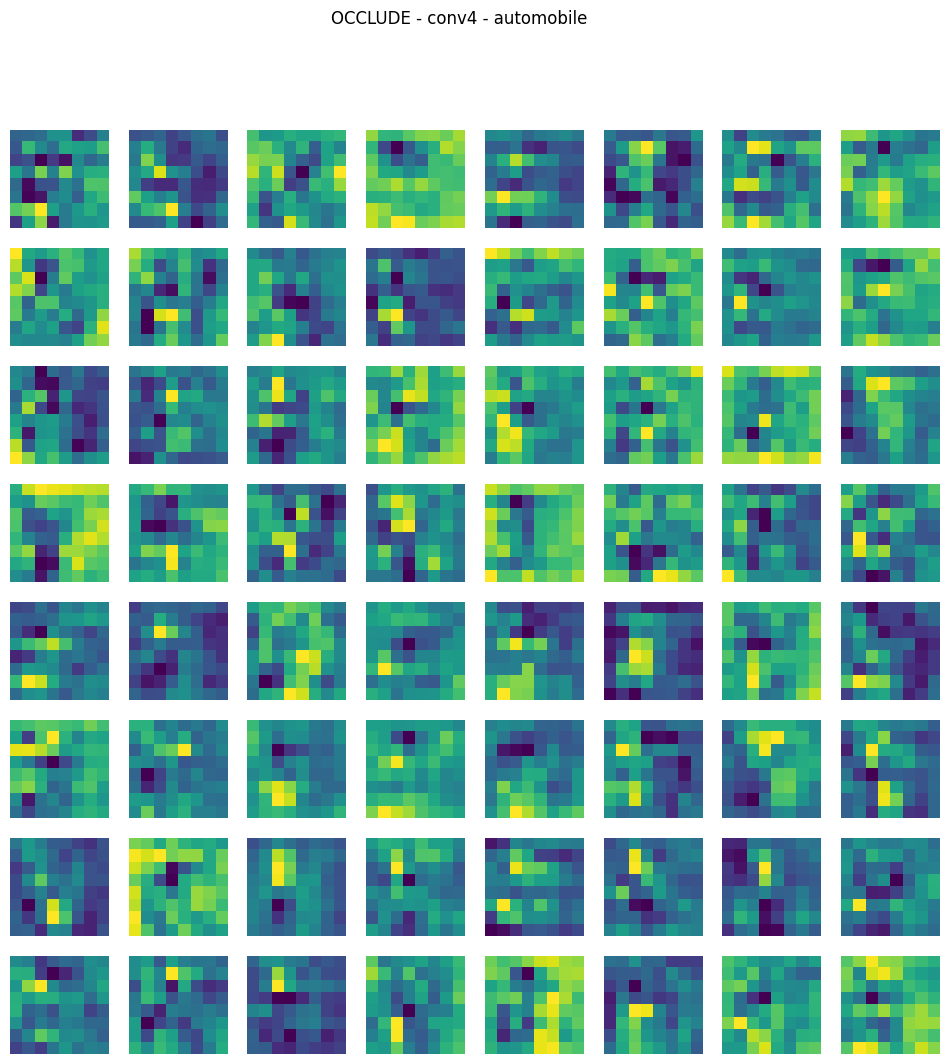

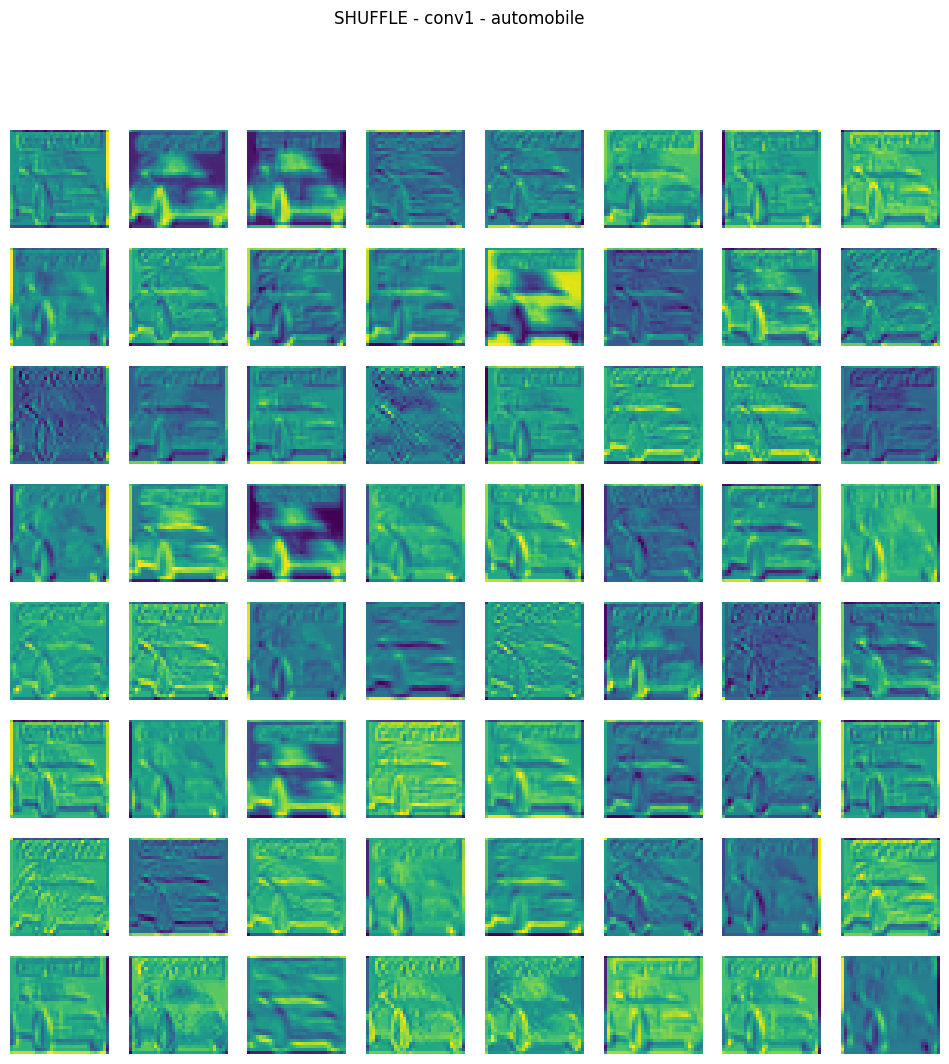

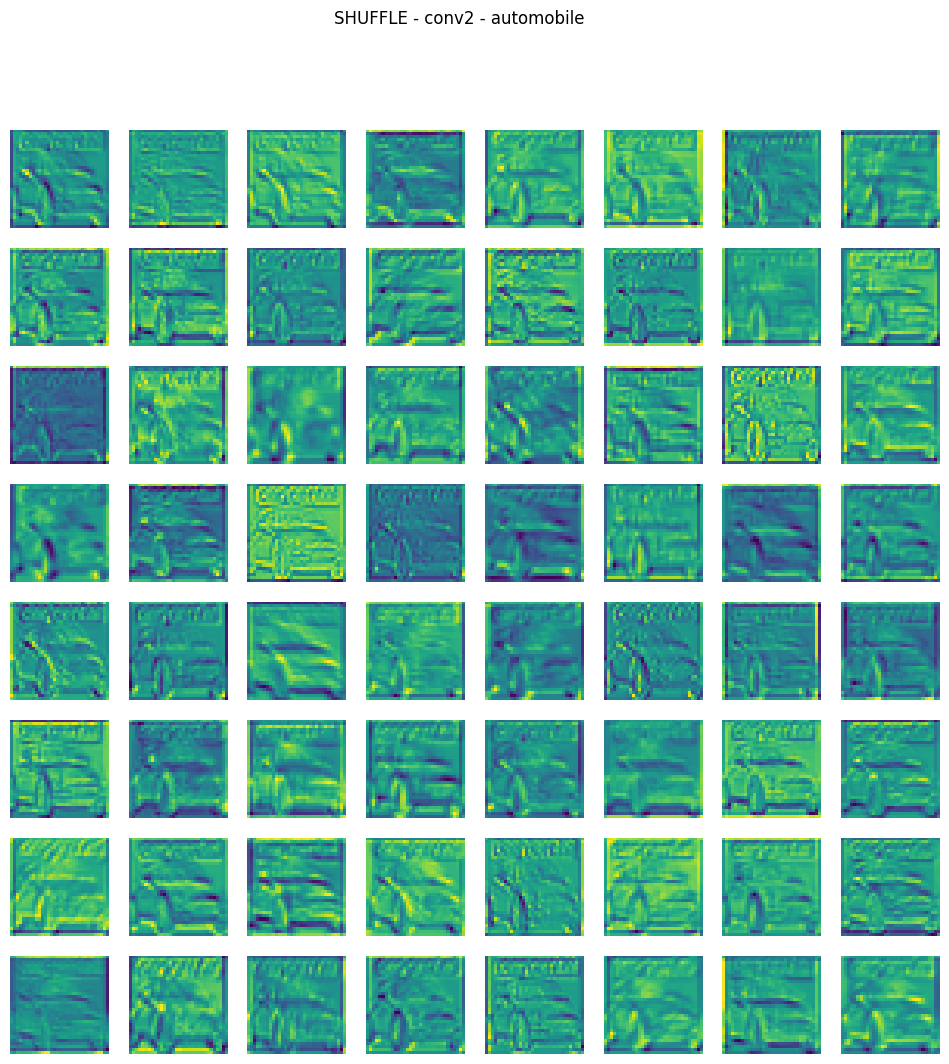

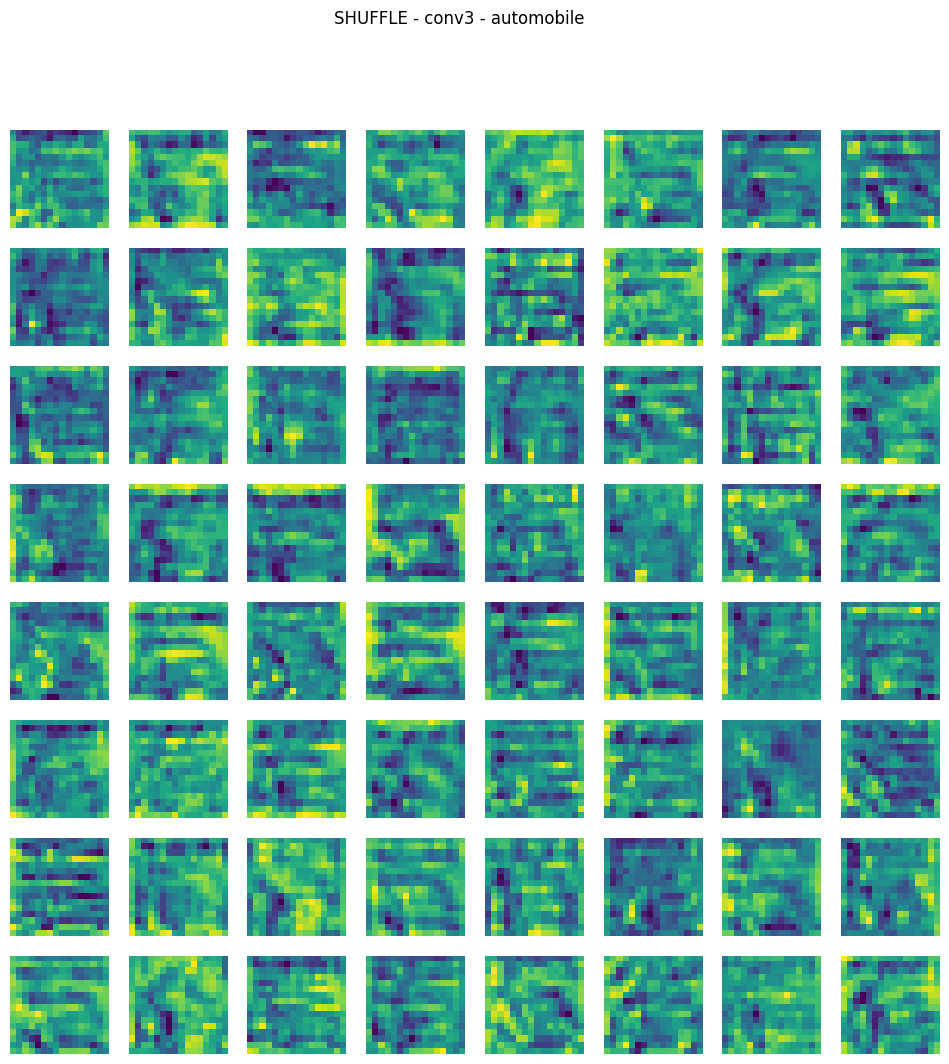

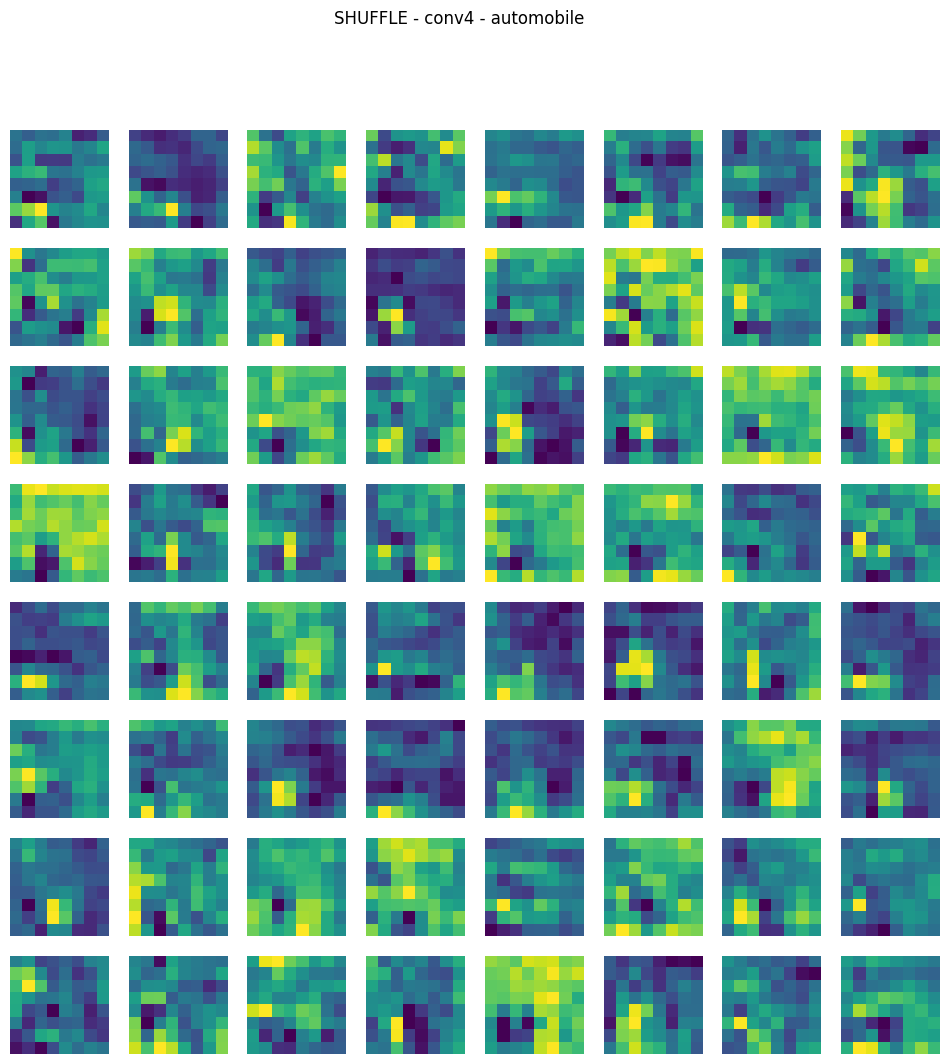

In [41]:
for intervention in ["patch", "occlude", "shuffle"]:
    # Apply the intervention on the sample image
    img_intervened = apply_intervention(sample_img, intervention=intervention)
    
    # Visualize feature maps / heatmaps for this intervened image
    visualize_feature_maps(img_intervened, intervention_name=intervention, class_name=class_names[sample_label])
